In [1]:
# 기존 CNN 모형: flatten layer를 통과하면 인접한 픽셀간의 정보가 손실되어 이미지의 특징을 시각적으로 볼 수 없는 단점
# Class Activation Map(CAM): 이미지의 특징을 시각화
# Global Average Pooling(GAP)방식 적용, 각 채널의 평균값으로 pooling

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

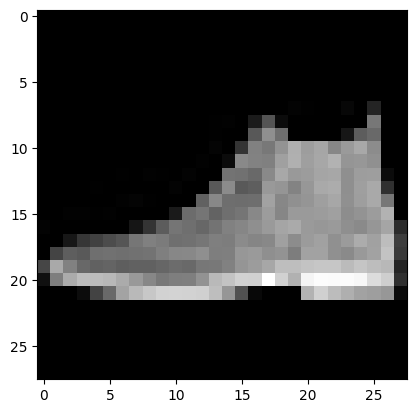

In [4]:
x_train, x_test = x_train / 255.0 , x_test / 255.0
plt.imshow(x_test[0], cmap='gray')
plt.show()

In [5]:
y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28,28)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='SAME', activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='SAME', activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='SAME', activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),        
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7

In [7]:
model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
938/938 [==============================] - 42s 44ms/step - loss: 0.6822 - accuracy: 0.7528 - val_loss: 0.5106 - val_accuracy: 0.8120
Epoch 2/5
938/938 [==============================] - 42s 45ms/step - loss: 0.4201 - accuracy: 0.8477 - val_loss: 0.4300 - val_accuracy: 0.8481
Epoch 3/5
938/938 [==============================] - 44s 47ms/step - loss: 0.3613 - accuracy: 0.8700 - val_loss: 0.3995 - val_accuracy: 0.8556
Epoch 4/5
938/938 [==============================] - 43s 46ms/step - loss: 0.3243 - accuracy: 0.8814 - val_loss: 0.3290 - val_accuracy: 0.8802
Epoch 5/5
938/938 [==============================] - 44s 47ms/step - loss: 0.3009 - accuracy: 0.8909 - val_loss: 0.3107 - val_accuracy: 0.8907


In [9]:
list(range(len(model.layers) - 1, -1, -1))

[8, 7, 6, 5, 4, 3, 2, 1, 0]

In [16]:
def get_cam_image(model_, x, img_size=(28, 28), layer_idx=None):
    if layer_idx is None:
        for layer_idx in range(len(model.layers) - 1, -1, -1):
            if type(model.layers[layer_idx]) == tf.keras.layers.Conv2D:
                break

    cam_model_ = tf.keras.models.Model(model_.inputs, [model_.layers[layer_idx].output, model_.output])
    conv_out, model_out = cam_model_(x)
    cam_images_ = np.zeros((x.shape[0], img_size[0], img_size[1]))

    for i, outs in enumerate(zip(conv_out, model_out)):
        c_out, m_out = outs
        predict_idx = np.argmax(m_out)
        chosen_weight = model_.layers[-1].weights[0][:, predict_idx]
        cam_img_ = np.zeros(c_out.shape[0:2])
        for j in range(c_out.shape[2]):
            cam_img_ += c_out[:, :, j] * chosen_weight[j]
        cam_images_[i] = cv2.resize(cam_img_.numpy(), img_size)
    return cam_images_

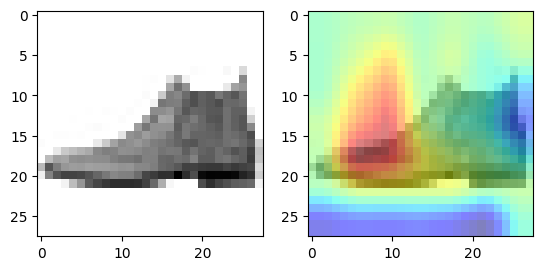

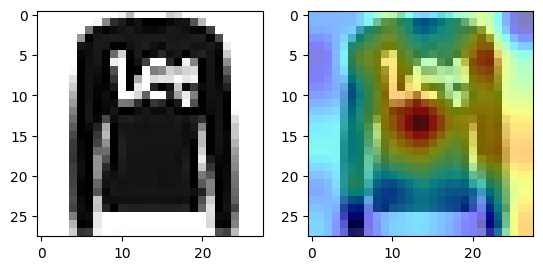

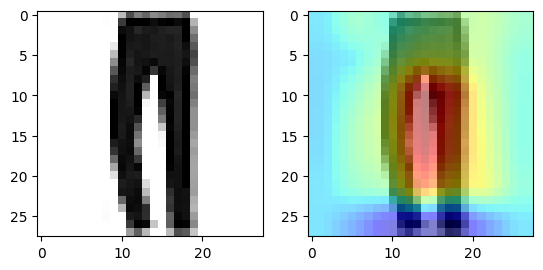

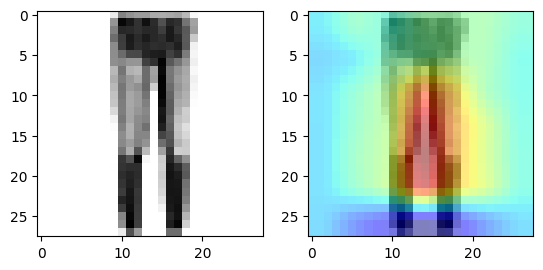

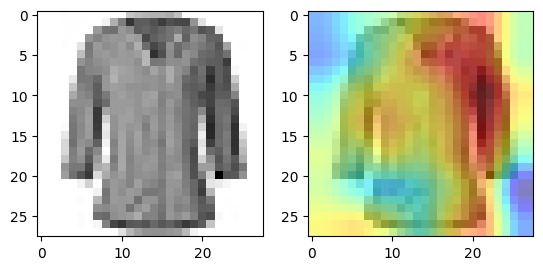

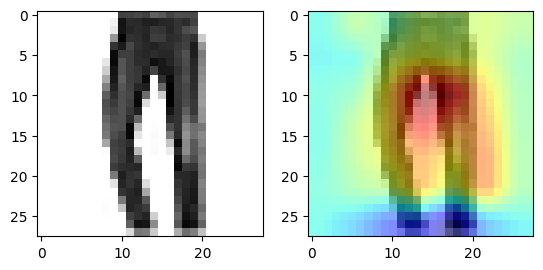

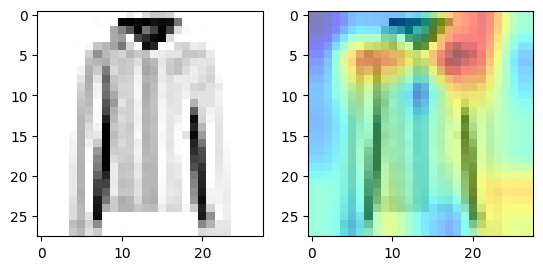

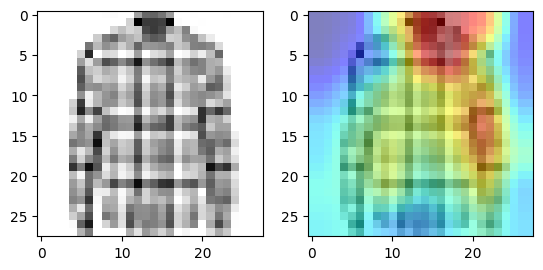

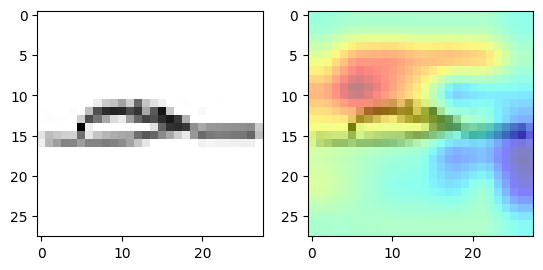

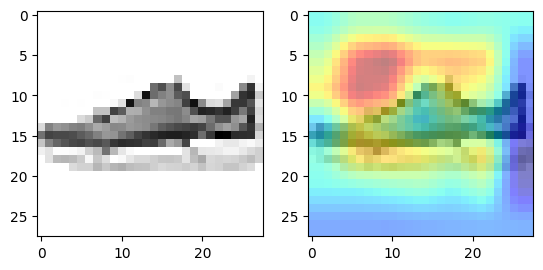

In [17]:
test_index = np.arange(10)
cam_img = get_cam_image(model, x_test[test_index], img_size=(28, 28))
for i, idx in enumerate(test_index):
    plt.subplot(1, 2, 1)
    plt.imshow(1-x_test[idx], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(1-x_test[idx], cmap='gray')
    plt.imshow(cam_img[i], cmap='jet', alpha=0.5)
    plt.show()